## Pre-Word2Vec Step: Defining the functions to save and load data

The following functions are not part of the Word2Vec model but are used to load the necessary preprocessed data upfront.<br>
For the Word2Vec model please scroll down. 

In [12]:
# Necessary imports
from pickle import dump, load
import numpy as np
import os

In [13]:
# Define path for datasets (containing preprocessed datasets)
path_for_datasets = './Preprocessed_datasets'

# Set path for Word2Vec results
path_for_word2vec = './Word2Vec_Results'
if not os.path.exists(path_for_word2vec):
    os.mkdir(path_for_word2vec)

**Functions to load and save datasets**

In [14]:
# Functions to save preprocessed datasets
def save_text(text, path, filename):
    dump(text, open(path + '/' + filename + '.pkl', 'wb'))
    print('Saved: %s' % filename)

In [15]:
# Function to load preprocessed datasets
def load_text(path, filename):
    data = load(open(path + '/' + filename + '.pkl', 'rb'))
    print('Loaded: %s' % filename)
    return data

In [16]:
# Load preprocessed data
text_en = load_text(path_for_datasets, 'preprocessed_text_en_small')
text_es = load_text(path_for_datasets, 'preprocessed_text_es_small')

Loaded: preprocessed_text_en_small
Loaded: preprocessed_text_es_small


**Functions to load and save Word2Vec results**

In [2]:
# Function to save numpy arrays (e.g. embedding_matrix)
def save_numpy_arrays(array, path, filename):
    np.save(path + '/' + filename, array)

In [4]:
# Define function to load numpy arrays (e.g. embedding_matrix)
def load_numpy_arrays(path, filename):
    array = np.load(path + '/' + filename + '.npy') 
    return array

<br><br><br><br>

# Word2Vec

### Word embeddings
Many machine learning algorithms and almost all deep learning architectures are incapable of directly processing strings or plain text in their raw form. Therefore it is necesarry to create a numeric (vector)representation for the words. 
A widely known vector representation is the one-hot-encoding. Thereby, however, the representations of the words do not capture their meanings, semantic relationships nor the different types of contexts they are used in (e.g. "Apple" can be a "fruit" or "company"). 
Hence, a better way of representing words as vectors is using word embeddings. The main idea behind word embeddings is that words with a similar context or same meaning have a similar representation. This representation is learned based on the usage of the words, which introduces some dependencies among the words.

### Word2Vec
One of the standard techniques to create word embeddings is Word2Vec. It is a statistical method for learning word embeddings from a text corpus. There are two different approaches to obtain Word2Vec embeddings (both using back-propagation to learn): 
- **Common Bag Of Words (CBOW)**: Learning embeddings by predicting the current word based on its context
- Skip Gram: Aim: Learning embeddings by predicting the surrounding words (context) for a given word
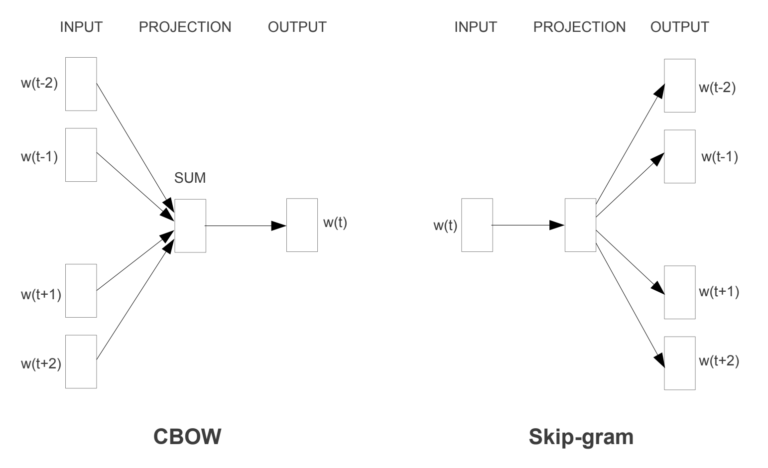

For my translation model I generated word embeddings for both languages (English, Spaning) using the Skip Gram approach of Word2Vec.

<br>

### Load necessary imports

In [17]:
# Necessary Imports
import collections
import math
import os
import random
import numpy as np
import tensorflow as tf

### Create word2index, index2word and convert the datasets

In [18]:
# Define max vocabulary size (for both datasets)
vocabulary_size = 10000

In [19]:
# Define special symbols
unk = '<UNK>' # for unknown words (needed for word2vec - see below)
eos = '<EOS>' # to mark the end of a sentence
sos = '<SOS>' # to mark the start of a sentence
pad = '<PAD>' # for padding

In [20]:
# Create data for vocabulary creation by combining all sentences to one big list of words
def format_data_for_word_count(text):
    data_for_word2vec = []
    for sentence in text:
        data_for_word2vec += sentence
    return data_for_word2vec

In [21]:
# Function for 
#  creation of word2index- and index2word-map 
#  mapping the word-based dataset to an index-based dataset
def build_dataset(text, vocabulary_size):
    # Consider the special symbols
    count = [[unk, -1]]
    count.extend([[eos, -1]])
    count.extend([[sos, -1]])
    count.extend([[pad, -1]])

    # Consider the most often used words of the text
    text_as_word_list = format_data_for_word_count(text)
    count.extend(collections.Counter(text_as_word_list).most_common(vocabulary_size - 4))
    
    del text_as_word_list # for memory
    
    # Create word2index map
    word2index_map = dict()
    for word, _ in count:
        word2index_map[word] = len(word2index_map)
    
    # Create index2word map (for 'retranslation')
    index2word_map = dict(zip(word2index_map.values(), word2index_map.keys()))
     
    # Map the text-data to index-data
    index_text = list()
    for sentence in text:
        index_sentence = list()
        for word in sentence:
            index = word2index_map.get(word, 0)
            index_sentence.append(index)
        index_text.append(index_sentence)
        
    return word2index_map, index2word_map, index_text

In [22]:
# Build datasets for the English and the Spanish language
word2index_map_en, index2word_map_en, index_text_en = build_dataset(text=text_en, vocabulary_size=vocabulary_size)
word2index_map_es, index2word_map_es, index_text_es = build_dataset(text=text_es, vocabulary_size=vocabulary_size)

In [19]:
# Save the results
save_text(index_text_en, path_for_datasets, 'index_text_en_small')
save_text(index_text_es, path_for_datasets, 'index_text_es_small')

save_text(index2word_map_en, path_for_word2vec, 'index2word_map_en')
save_text(index2word_map_es, path_for_word2vec, 'index2word_map_es')

save_text(word2index_map_en, path_for_word2vec, 'word2index_map_en')
save_text(word2index_map_es, path_for_word2vec, 'word2index_map_es')

Saved: index_text_en_small
Saved: index_text_es_small
Saved: index2word_map_en
Saved: index2word_map_es
Saved: word2index_map_en
Saved: word2index_map_es


<br>

## Define the Word2Vec-model

In [20]:
# Define some constants
batch_size = 16
embedding_size = 32  # Dimension of the embedding vector. - Also tested embedding_size = 64 with worse results
skip_window = 2  # How many words to consider left and right.
num_skips = 2  # How many times to reuse an input to generate a label.
num_sampled = 32  # Number of negative examples to sample.

In [27]:
# Create the directory for logs
log_dir = './' + path_for_word2vec + '/Word2Vec_log'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

**Helper-function for batch generation**

In [22]:
def generate_batch(batch_size, num_skips, skip_window, data):
    global sentence_index
    global word_index
    global buffer
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1  # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span) 
    while word_index + span > len(data[sentence_index]):
        word_index = 0
        sentence_index += 1
    buffer.extend(data[sentence_index][word_index:word_index + span])
    word_index += span
    for i in range(batch_size // num_skips): # Floor Division
        context_words = [w for w in range(span) if w != skip_window]
        words_to_use = random.sample(context_words, num_skips)
        for j, context_word in enumerate(words_to_use):
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[context_word]
        if sentence_index == len(data):
            sentence_index = 0
        if word_index > len(data[sentence_index]):
            buffer.extend(data[sentence_index][0:len(data[sentence_index])])
            word_index = span
            sentence_index += 1
        elif word_index == len(data[sentence_index]):
            buffer.extend(data[sentence_index][0:span])
            word_index = span
            sentence_index += 1
        else:
            buffer.append(data[sentence_index][word_index])
            word_index += 1
    # Backtrack a little bit to avoid skipping words in the end of a batch
    word_index = (word_index + len(data[sentence_index]) - span) % len(data[sentence_index])
    return batch, labels

In [23]:
# Test generate_batch()-function
word_index = 0
sentence_index = 0
batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=2, data=index_text_en)
for i in range(8):
    print(batch[i], index2word_map_en[batch[i]], '->', labels[i, 0], index2word_map_en[labels[i, 0]])

2430 resumed -> 1458 session
2430 resumed -> 15 i
4 the -> 5 of
4 the -> 2430 resumed
1458 session -> 2430 resumed
1458 session -> 4 the
5 of -> 4 the
5 of -> 26 european


**Definition of Word2Vec-model**

In [24]:
graph = tf.Graph()

with graph.as_default():

    # Input data
    with tf.name_scope('inputs'):
        train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
        train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])

    # Look up embeddings for inputs
    with tf.name_scope('embeddings'):
        embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
        embed = tf.nn.embedding_lookup(embeddings, train_inputs)

    # Construct the variables for the NCE loss
    with tf.name_scope('weights'):
        nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size], stddev=1.0 / math.sqrt(embedding_size)))
    with tf.name_scope('biases'):
        nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

    # Compute the average NCE loss for the batch.
    with tf.name_scope('loss'):
        loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_weights,
                                             biases=nce_biases,
                                             labels=train_labels,
                                             inputs=embed,
                                             num_sampled=num_sampled,
                                             num_classes=vocabulary_size)) # tf.nce_loss automatically draws a new sample of the negative labels each time we evaluate the loss.
    # Add the loss value as a scalar to summary.
    tf.summary.scalar('loss', loss)

    # Construct the SGD optimizer using a learning rate of 1.0.
    with tf.name_scope('optimizer'):
        optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

    # Compute the cosine similarity between minibatch examples and all embeddings.
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
    normalized_embeddings = embeddings / norm

    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
    normalized_embeddings = embeddings / norm
    
    # Merge all summaries.
    merged = tf.summary.merge_all()

    # Add variable initializer.
    init = tf.global_variables_initializer()

    # Create a saver.
    saver = tf.train.Saver()

**Generate Embeddings by training the model**

In [29]:
# Function for generating embeddings
def generate_embeddings(data, num_steps, modelName):
    word_index = 0
    sentence_index = 0

    with tf.Session(graph=graph) as session:
        # Initialize all variables
        init.run()

        average_loss = 0
        for step in range(num_steps):
            batch_inputs, batch_labels = generate_batch(batch_size, num_skips, skip_window, data)
            print(batch_inputs.shape)
            feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}

            # Performing one update step by evaluating the optimizer op and the merged op to get all summaries from the returned "summary" variable 
            _, summary, loss_val = session.run([optimizer, merged, loss], feed_dict=feed_dict)
            average_loss += loss_val

            # Print intermediate results for process control
            if step % 2000 == 0:
                if step > 0:
                    average_loss /= 2000 # Average loss = estimate of the loss over the last 2000 batches
                print('Average loss at step ', step, ': ', average_loss)
                average_loss = 0

        # Normalize final embeddings
        final_embeddings = normalized_embeddings.eval()

        # Save the model
        saver.save(session, os.path.join(log_dir, modelName + '.ckpt'))
    
    return final_embeddings

In [ ]:
# Train the model with English dataset
final_embeddings_en = generate_embeddings(data=index_text_en, num_steps=100001, modelName='word2vec_model_en')

In [ ]:
# Train the model with Spanish dataset
final_embeddings_es = generate_embeddings(data=index_text_es, num_steps=100001, modelName='word2vec_model_es')

<br>

## Save (and load) word-embeddings

**Save word-embeddings**

In [ ]:
save_numpy_arrays(final_embeddings_en, path_for_word2vec, 'embedding_matrix_en')
save_numpy_arrays(final_embeddings_es, path_for_word2vec, 'embedding_matrix_es')

**Load word_embeddings**

In [7]:
final_embeddings_en = load_numpy_arrays(path_for_word2vec, 'embedding_matrix_en')
final_embeddings_es = load_numpy_arrays(path_for_word2vec, 'embedding_matrix_es')

<br>

## Visualize the word embeddings

In [8]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [23]:
# Function to draw visualization of distance between embeddings
def plot_with_labels(low_dim_embs, labels, filename):
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
    plt.savefig(filename)

In [28]:
def visualize_embeddings(embedding_matrix, index2word_map, filename):
    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
    plot_only = 500
    low_dim_embs = tsne.fit_transform(embedding_matrix[:plot_only, :])
    labels = [index2word_map[i] for i in range(plot_only)]
    plot_with_labels(low_dim_embs, labels, os.path.join(log_dir, filename + '.png'))

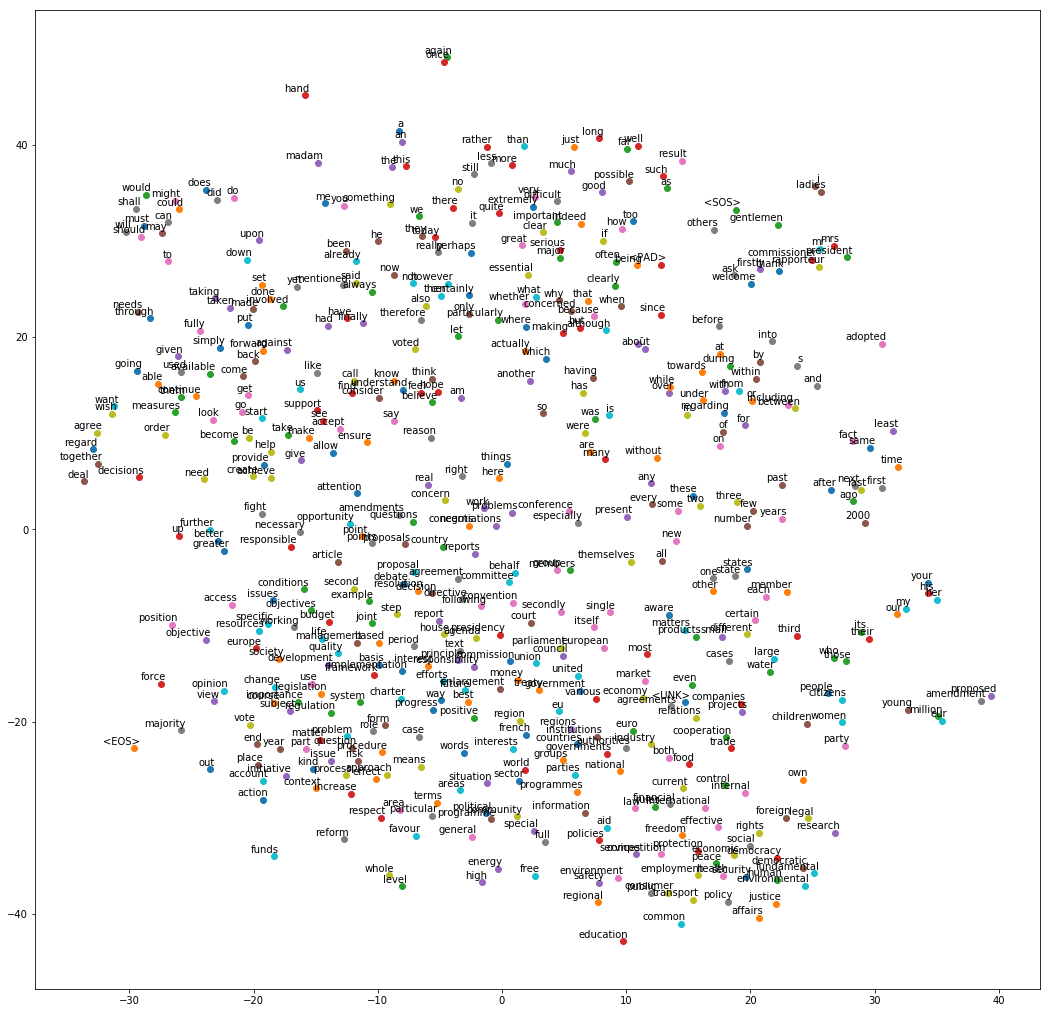

In [29]:
# Visualize embeddings of English dataset
visualize_embeddings(final_embeddings_en, index2word_map_en, 'embedding_en')

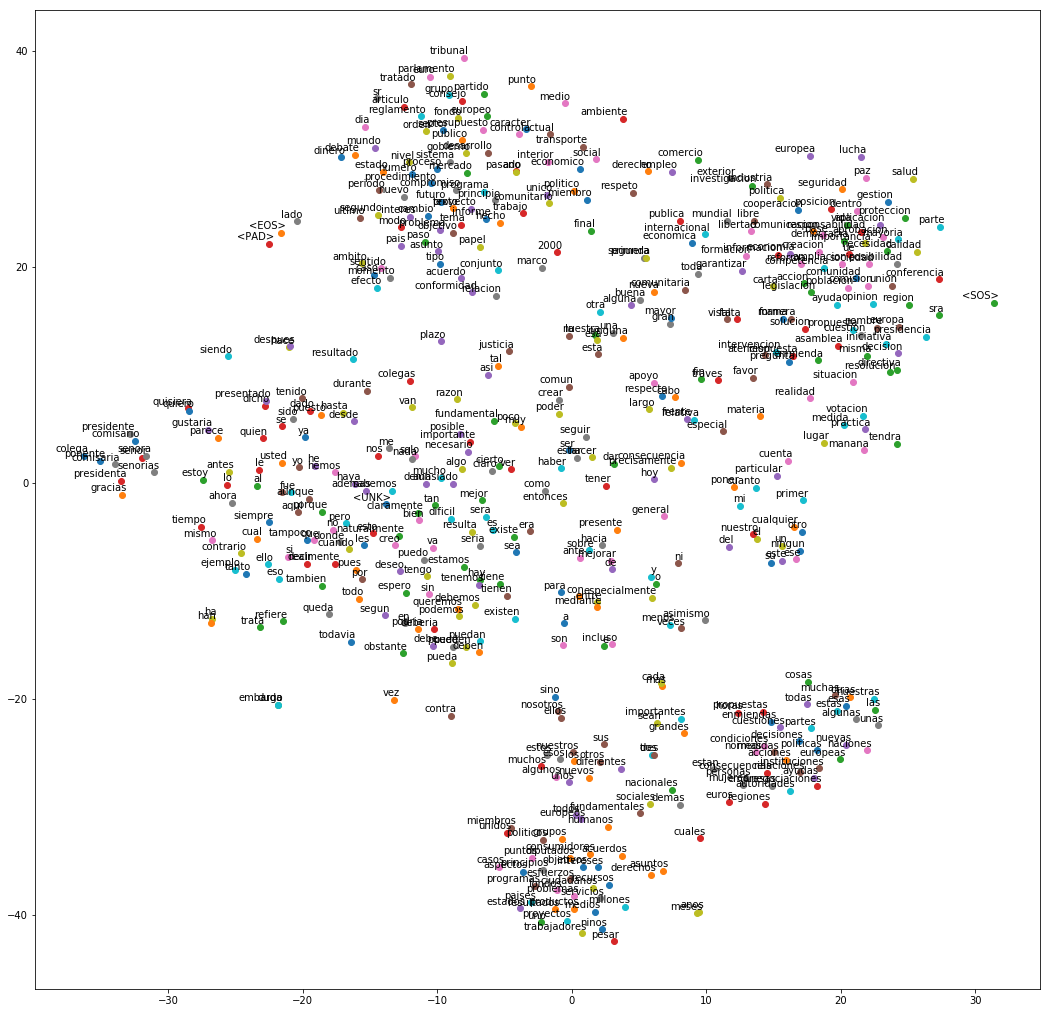

In [30]:
# Visualize embeddings of English dataset
visualize_embeddings(final_embeddings_es, index2word_map_es, 'embedding_es')